# StrokeSafe Feature - Analysis and Model Development
### Background
In the ever-evolving landscape of wearable technology, the introduction of our hallmark product, *SenseBand*, marks a significant leap forward in personal health monitoring. This innovative device, powered solely by the user's body heat, represents a blend of cutting-edge technology and practical health management. SenseBand offers a comprehensive suite of health indicators, including blood pressure, body temperature, and breathing rate, among others.

### Business situation description

Building on its robust health monitoring capabilities, *SenseBand* is now poised to introduce a groundbreaking feature: *StrokeSafe*. StrokeSafe leverages advanced algorithms and machine learning models to analyze the myriad of health data collected by the SenseBand. By identifying patterns and markers that may indicate the early signs of a stroke, StrokeSafe aims to provide users with a preemptive warning system. This feature could potentially revolutionize how we approach stroke prevention, offering a new layer of security and peace of mind to those at risk.

To validate the feasibility and effectiveness of *StrokeSafe*, a thorough analysis of health data sets is imperative. By employing machine learning techniques, we can sift through vast amounts of health metrics collected by SenseBand to identify which factors are most indicative of stroke risk. This involves not just the analysis of traditional indicators like blood pressure and heart rate, but also more nuanced metrics that wearable technologies like SenseBand can monitor, such as difficulty in breathing. The goal of this analysis is to develop a predictive model that is both accurate and reliable, providing users with timely and critical health alerts.

The journey of integrating StrokeSafe into SenseBand is a testament to our commitment to enhancing health outcomes. As we move forward, the focus will be on refining our algorithms, ensuring user privacy and data security, and continuously improving the predictive capabilities of our models. The potential of StrokeSafe to save lives and improve the quality of life for many is immense, and we are at the forefront of making this potential a reality.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

import sklearn.externals as extjoblib
import joblib

## Source Data Background
#### source data and link: https://www.kaggle.com/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset?resource=download


In [13]:
#Load data - data file is local
data = pd.read_csv('Disease_symptom_and_patient_profile_dataset.csv')

data.head()

print ("number of rows: ", len(data))

number of rows:  349


### Features information
##### *note*: This dataset provides a comprehensive compilation of symptoms and patient profiles for a wide range of diseases.
##### *Data size*: 20kb file size, tabular format, 349 rows x 11 columns

- **Disease** : The name of the disease or medical condition under consideration.
- **Fever**: Indicates whether the patient has a fever (Yes/No).
- **Cough**: Indicates whether the patient has a cough (Yes/No).
- **Fatigue**: Indicates whether the patient experiences fatigue (Yes/No).
- **Difficulty Breathing**: Indicates whether the patient has difficulty breathing (Yes/No).
- **Age**: The age of the patient in years.
- **Gender**: The gender of the patient (Male/Female).
- **Blood Pressure**: The blood pressure level of the patient (Normal/High).
- **Cholesterol Level**: The cholesterol level of the patient (Normal/High).
- **Outcome Variable**: The outcome variable indicating the result of the diagnosis or assessment for the specific disease(Positive/Negative)

In [14]:
#check is any nulls in dataset - will need to drop rows with missing data
data.isnull().sum()
#no null data was found

Disease                 0
Fever                   0
Cough                   0
Fatigue                 0
Difficulty Breathing    0
Age                     0
Gender                  0
Blood Pressure          0
Cholesterol Level       0
Outcome Variable        0
dtype: int64

In [15]:
#basic data info

#as backup, drop any na records
data=data.dropna()
#df.groupby(['Animal']).mean()
grouped_sorted = data.groupby('Disease').size().reset_index(name='Counts').sort_values(by='Counts', ascending=False)

print("Disease record counts: \n", grouped_sorted)

Disease record counts: 
                               Disease  Counts
6                              Asthma      23
101                            Stroke      16
77                       Osteoporosis      14
51                       Hypertension      10
69                           Migraine      10
..                                ...     ...
78       Otitis Media (Ear Infection)       1
79                     Ovarian Cancer       1
80                  Pancreatic Cancer       1
21   Chronic Obstructive Pulmonary...       1
0                                Acne       1

[116 rows x 2 columns]


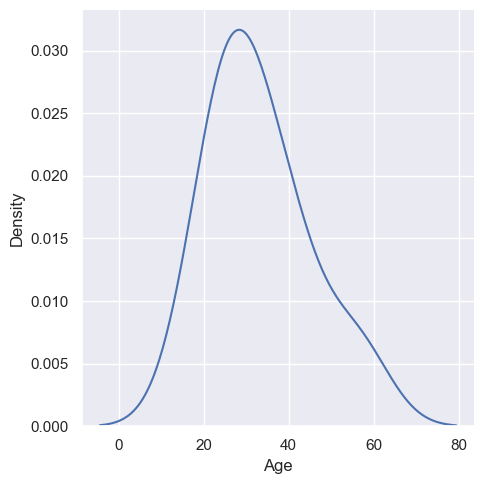

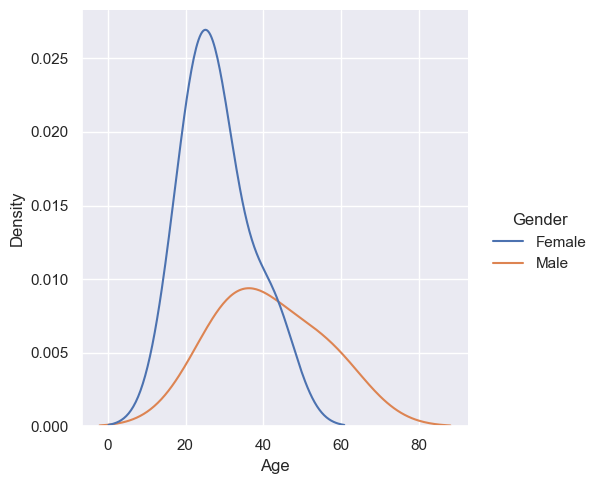

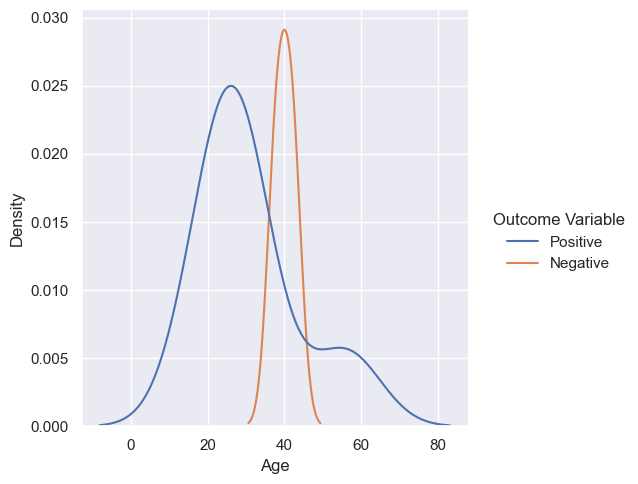

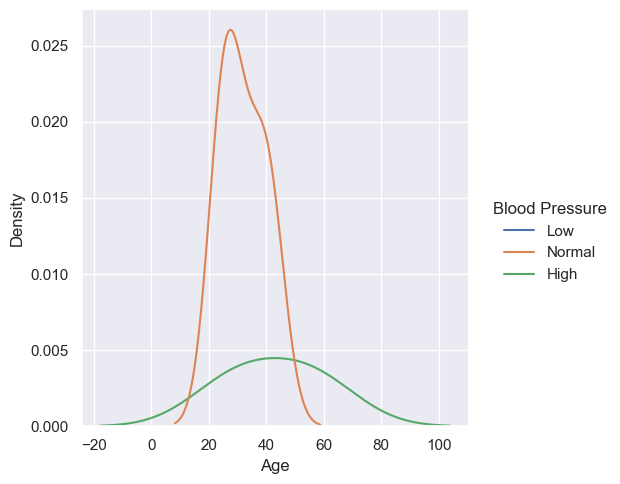

In [16]:
#introductory data analysis to understand data set

#create data set for influenza only
#print(df.loc[df['B'].isin(['one','three'])])
flu = data.loc[data['Disease'].isin(['Influenza'])]
#stroke = data.loc[data['Disease'].isin(['Stroke'])]

df = flu

sns.displot(data=df, x="Age", kind="kde")

sns.displot(data=df, x="Age", hue="Gender", kind="kde")

sns.displot(data=df, x="Age", hue="Outcome Variable", kind="kde")

sns.displot(data=df, x="Age", hue="Blood Pressure", kind="kde")

#note analysis of Flu data indicated dataset too small for effective analysis

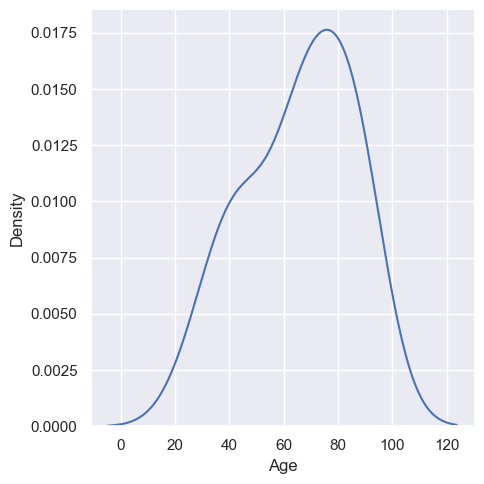

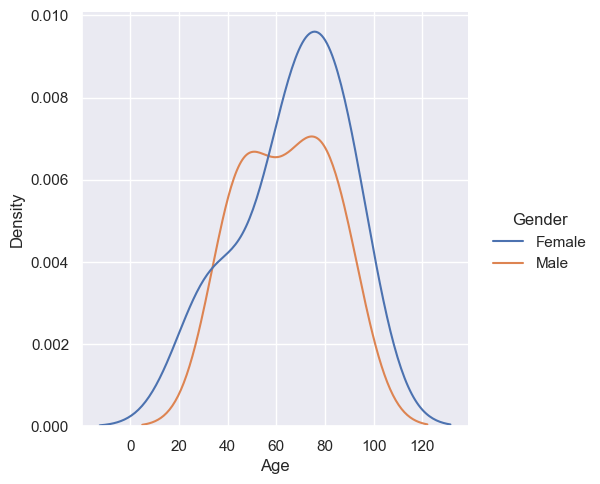

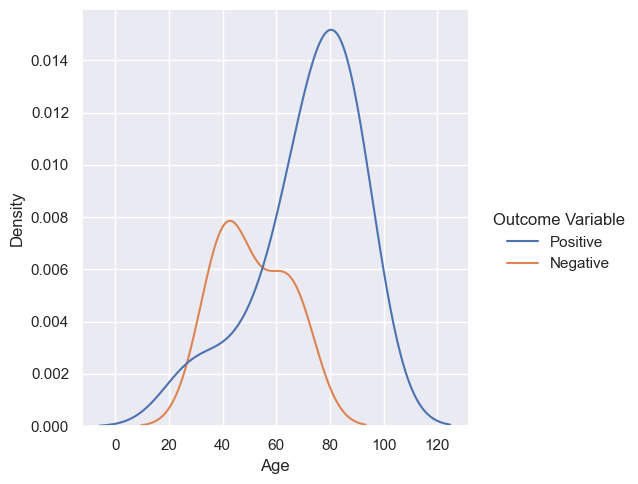

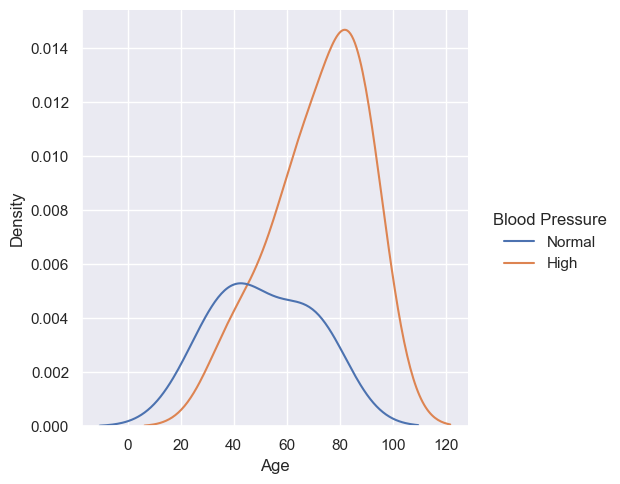

In [17]:
#introductory data analysis to understand data set

#create data set for stroke only
#print(df.loc[df['B'].isin(['one','three'])])
#flu = data.loc[data['Disease'].isin(['Influenza'])]
stroke = data.loc[data['Disease'].isin(['Stroke'])]

df = stroke

sns.displot(data=df, x="Age", kind="kde")

sns.displot(data=df, x="Age", hue="Gender", kind="kde")

sns.displot(data=df, x="Age", hue="Outcome Variable", kind="kde")

sns.displot(data=df, x="Age", hue="Blood Pressure", kind="kde")

#note analysis of Flu data indicated dataset too small for effective analysis

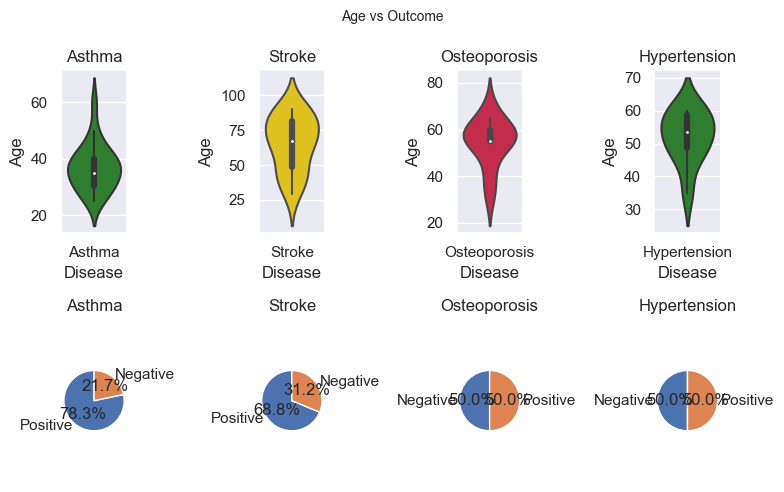

In [18]:
#violin plots of selected disease types
top_diseases = data['Disease'].value_counts().nlargest(4).index.tolist()

#use this to review specific diseases
focus_diseases =['Influenza','Common Cold','Asthma']

colors = ['forestgreen', 'gold', 'crimson']

num_diseases = len(top_diseases)
num_columns = num_diseases
fig, axes = plt.subplots(2, num_columns, figsize=(8, 5))

diseases_to_analyze = top_diseases

for i, disease in enumerate(diseases_to_analyze):
    filtered_df = data[data['Disease'] == disease]

    sns.violinplot(x='Disease', y='Age', data=filtered_df, ax=axes[0, i], color=colors[i % len(colors)])
    axes[0, i].set_title(disease)
    axes[0, i].set_xlabel('Disease')
    axes[0, i].set_ylabel('Age')

    outcome_counts = filtered_df['Outcome Variable'].value_counts()

    axes[1, i].pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1, i].set_title(disease)
    axes[1, i].axis('equal')
    
fig.suptitle('Age vs Outcome', fontsize = 10)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.tight_layout()
plt.show()


In [19]:
#review of data types in dataframe

# for col in flu.columns:
#     print(flu[col].dtype)

df = flu

def show_basic_pd_stats(df):
    result = pd.DataFrame({"values":{col:df[col].unique() for col in df},
                  'type':{col:df[col].dtype for col in df},
                  'unique values':{col:len(df[col].unique()) for col in df},
                  'NA values':{col:str(round(sum(df[col].isna())/len(df),2))+'%' for col in df},
                  'Duplicated Values':{col:sum(df[col].duplicated()) for col in df}
                 })
    return result

print("\n length of dataset: ",len(df))
print("Flu")
print(show_basic_pd_stats(flu))

print("\n\n Full dataset")
show_basic_pd_stats(data)


 length of dataset:  8
Flu
                                        values    type  unique values  \
Disease                            [Influenza]  object              1   
Fever                                [Yes, No]  object              2   
Cough                                [No, Yes]  object              2   
Fatigue                              [Yes, No]  object              2   
Difficulty Breathing                 [Yes, No]  object              2   
Age                   [19, 25, 30, 38, 42, 56]   int64              6   
Gender                          [Female, Male]  object              2   
Blood Pressure             [Low, Normal, High]  object              3   
Cholesterol Level               [Normal, High]  object              2   
Outcome Variable          [Positive, Negative]  object              2   

                     NA values  Duplicated Values  
Disease                   0.0%                  7  
Fever                     0.0%                  6  
Cough       

,values,type,unique values,NA values,Duplicated Values
Disease,"[Influenza, Common Cold, Eczema, Asthma, Hyper...",object,116,0.0%,233
Fever,"[Yes, No]",object,2,0.0%,347
Cough,"[No, Yes]",object,2,0.0%,347
Fatigue,"[Yes, No]",object,2,0.0%,347
Difficulty Breathing,"[Yes, No]",object,2,0.0%,347
Age,"[19, 25, 28, 29, 30, 31, 32, 35, 38, 39, 40, 4...",int64,26,0.0%,323
Gender,"[Female, Male]",object,2,0.0%,347
Blood Pressure,"[Low, Normal, High]",object,3,0.0%,346
Cholesterol Level,"[Normal, Low, High]",object,3,0.0%,346
Outcome Variable,"[Positive, Negative]",object,2,0.0%,347


                         Fever     Cough   Fatigue  Difficulty Breathing  \
Fever                 1.000000 -0.447214  0.462250             -0.218218   
Cough                -0.447214  1.000000 -0.620174              0.487950   
Fatigue               0.462250 -0.620174  1.000000              0.181568   
Difficulty Breathing -0.218218  0.487950  0.181568              1.000000   
Age                   0.207950 -0.487173  0.158209             -0.520810   
Gender               -0.654654  0.097590 -0.221917              0.047619   
Blood Pressure       -0.544949  0.313340 -0.367058              0.152894   
Cholesterol Level     0.045787  0.102383 -0.063495              0.209822   
Outcome Variable     -0.077850  0.243709  0.021592              0.254824   

                           Age    Gender  Blood Pressure  Cholesterol Level  \
Fever                 0.207950 -0.654654       -0.544949           0.045787   
Cough                -0.487173  0.097590        0.313340           0.102383   
Fa

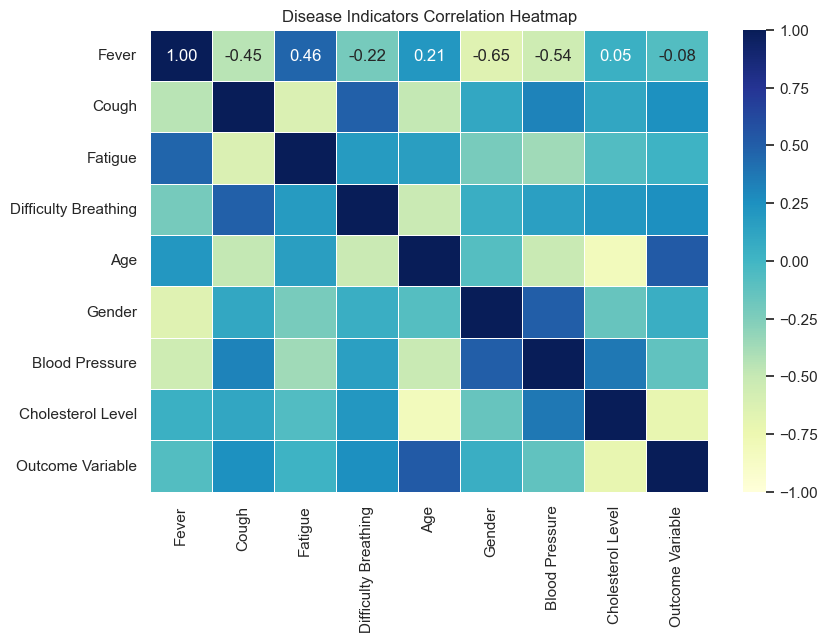

In [22]:
#correlation analysis and heatmap
sns.set_theme()

df = stroke.copy(deep=True)
df = df.loc[:, df.columns != 'Disease']
#do some data cleanup
change_col = ['Fever','Cough','Fatigue','Difficulty Breathing','Gender','Blood Pressure','Cholesterol Level','Outcome Variable']
encoder = LabelEncoder()
for i in change_col:
    df[i] = encoder.fit_transform(df[i])

corr_grid = df.corr(method="pearson")

f, ax = plt.subplots(figsize=(9, 6))
#sns.heatmap(corr_grid, annot=True, linewidths=.5, ax=ax, fmt='.2f', cmap="crest", cbar=True)
sns.heatmap(corr_grid, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Disease Indicators Correlation Heatmap")

#print(corr_grid)

## Correlation Analysis ##

Review of the stroke subset of data shows probable correlations between age and outcome, gender and blood pressure, cough and difficulty breathing, blood pressure and cough, and negative correlation between blood pressure and fever.  Reviewing the outcome only target feature, there appears to be correlations for Cholesterol level, age, cough, and difficulty breathing.

### OLS exploratory modeling Residuals analysis

In [ ]:
#lets plot some residuals to explore some key appearing features

#let's take a look at the residuals from a linear model
sns.set_theme(style="whitegrid")

print(len(df))

# Plot the residuals after fitting a linear model
sns.residplot(data=df, x="Cholesterol Level", y="Outcome Variable")

### Exploratory Modeling ###

In order to determine if the features indicate a possible prediction capability for the StrokeSafe monitoring device, we begin with simple linear regression models.

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

#train test split

X = df.drop(columns = 'Outcome Variable') #features
y = df['Outcome Variable'] #labels

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 4321)

# Need to transform features that are categorical
categorical_features = ['Gender','Blood Pressure','Cholesterol Level']

# Create a ColumnTransformer to one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Leave numerical features unchanged
)

# Create a pipeline that first one-hot encodes the data then applies linear regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
model.fit(x_train, y_train)

# Predict on the testing set
y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"OLS Mean Squared Error: {mse}")

print(f"OLS Model summary")
print(f"OLS R2: {model.score(X, y)}")


###  Attempt at Regularization for improvement

We will use ElasticNet which is a combination of Lasso and Ridge Regression regularization.  Mutliple ratios between l1 and l2 norms were tried to determine impact.

In [ ]:
#try Lasso and Ridge combination through ElasticNet

from sklearn.linear_model import ElasticNet

model = ElasticNet(random_state = 0, l1_ratio = 0.25)
#train the model
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"ElasticNet Mean Squared Error: {mse}")

print(f"ElasticNet Model summary")
print(f"ElasticNet R2: {model.score(X, y)}")


### Regularization Attempt Results

Results were not optimal, R squared declined significantly.  The small dataset is likely contributing to this difficulty.  Next we will get more information for OLS regression using the statsmodels package which has a nice summary output.

In [ ]:
#get various model summaries based on what has been learned so far from correlation analysis and initial modeling
import statsmodels.formula.api as smf
import statsmodels.api as sm

#attempt model with all features, mainly to review Coefs for each
formula_all = "Q('Outcome Variable') ~ Fever + Cough + Fatigue + Q('Difficulty Breathing') + Gender + Q('Blood Pressure') + Q('Cholesterol Level')"

#put train samples back into combined form
combined_train = pd.concat([y_train,x_train],axis=1)

model = smf.ols(data = combined_train, formula=formula_all).fit()

print(model.summary())


### Results of Initial Exploratory Data Analysis

At this point, there is not enough data for a flu or an effective stroke only predictoin based on the dataset that aligns to the data the instant sensors can monitor.  The residual analysis was on just a few data points.  The R squared was significant for Stroke positive prediction for the patients suspected of having a Stroke.  This indicates that an overall prediction of Stroke risk may be useful, due to the high cost and impact to a patient of a stroke and the potential predictive power of body temperature, breathing patterns, blood pressure, and colesterol monitoring capabilities of the instant sensors.  Review of the OLS prediction for each of these features indicates significance based on the p-values.  We will focus further analysis on an overall stroke prediction analysis.  This is to look for indication of potential predictive power that warrants further study with more robust data collection.

Also to note, review of the p-values for some features indicated limited importance.  To simplify our model, we will drop Gender from the model.  Due to the goal of simplicity for user experience, our business goals want to limit any additional human input required and also avoid more subjective data points.  We do not want users to have to stop and answer questions.  For these reasons, we will also remove *fatigue* from the feature list as this would require a user to input a subjective response.

### Further data transformation
Transform dataset to include a new target variable that indicates a true postive stroke (1) versus a not-stroke (0).  Include all available data points and regenerate test and train sets.  Further supervised modeling methods are to be used along with more robust cross validation and hyperparameter tuning.

In [ ]:
stfocus_data = data.copy(deep=True)

stfocus_data['TPStrokeOutcome'] = (stfocus_data['Disease'] == 'Stroke') & (stfocus_data['Outcome Variable'] == 'Positive')

stfocus_data.head()

print("occurences of stroke true positive: ", stfocus_data['TPStrokeOutcome'].value_counts()[True])

In [ ]:
#filter to stroke to check on new column

st_filter = stfocus_data.query("Disease == 'Stroke'")
st_filter.head()

### Notes on data analysis
Unfortunately, this is a small dataset.  There are only 11 rows with positive stroke outcome.  This makes the data sample small and also highly imbalanced.  However, we will do our best with this analysis.

### Data and feature transformations for modeling

Encode categorical columns to support OLS, SVM, etc.  Remove Outcome Variable column as it is no longer needed.  Also remove the features that were earlier determine either to not be significant or to be against the business goals of this product feature.

Since this is an imbalanced dataset, use the stratify parameter in train_test_split to get a more balanced percentage of stroke positive rows in the train and test sets.

In [ ]:
# note, data appears valid

#run through data cleaning and transform to prepare for further modeling

#label encodings
df = stfocus_data.copy(deep=True)  #note that data is small, so not too worried about memory space limits due to having multiple copies of dataframe

df = df.loc[:, df.columns != 'Disease']
df = df.loc[:, df.columns != 'Outcome Variable']
df = df.loc[:, df.columns != 'Gender']
df = df.loc[:, df.columns != 'Cough']
df = df.loc[:, df.columns != 'Fatigue']

#do some data cleanup
change_col = ['Fever', 'Difficulty Breathing','Blood Pressure','Cholesterol Level','TPStrokeOutcome']
encoder = LabelEncoder()
for i in change_col:
    df[i] = encoder.fit_transform(df[i])


In [ ]:
#create features and labels data sets for the train/test split
X = df.drop(columns = 'TPStrokeOutcome') #features
y = df['TPStrokeOutcome'] #labels

#create training and test data, since highly imbalanced data set, try to ensure good sampling of postive outcomes with the stratify parameter
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 4321, stratify=y)

### Prepare Algorithm set and hyperparameters

Set up all the models to train and test with hyperparameters to enable a grid search for best model.  Multiple algorithmns are used for comparison - Linear Regression, Decision Tree, Random Forest, SVM (with multiple kernels), NaiveBayes, KNN, Gradient Boosting Machines.  These models were chosen as potentials to work well with small datasets, can do well with limited parameter set.  For SVM, multiple kernels will be used to test variations.

In [ ]:
# set up the model configurations

#establish name for model to use in pipeline, the parameter names need to match
model_ref = "model"
mr = model_ref + "__"  #{mr}

              # 'SVM':
              # {"model": svm.SVC(probability=True),
              #  "params": {f"{mr}kernel": ['linear', 'poly', 'rbf', 'sigmoid'],f"{mr}gamma": ["auto","scale"]}
              # },

models_config = {'Logistic Regression': 
              {"model": LogisticRegression(),
               "params": {f"{mr}penalty": ['elasticnet','l1','l2'],f"{mr}solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']}
              },
              
              'Decision Tree': 
              {"model": tree.DecisionTreeClassifier(),
               "params": {f"{mr}criterion": ['gini','entropy'],f"{mr}max_depth": [3, 5, 7, 10, 14, 18, 20],f"{mr}min_samples_split": [2, 4, 6],f"{mr}min_samples_leaf": [i for i in range(1, 6)]}
              },
              
              'Random Forest': 
              {"model": RandomForestClassifier(),
               "params": {f"{mr}n_estimators": [100, 200, 300],f"{mr}max_features": ["auto", "log2", "sqrt", None],f"{mr}max_depth": [1, 3, 5, 7, 10, 12, 15, 20, 25, 30, 40],f"{mr}min_samples_split": [2, 4, 6, 8, 10]}
              },
              
              'SVM':
              {"model": svm.SVC(),
               "params": {f"{mr}kernel": ['linear', 'poly', 'rbf', 'sigmoid'],f"{mr}gamma": ["auto","scale"], f"{mr}class_weight": ["balanced"]}
              },
              
              'NaiveBayes' :
              {"model": GaussianNB(),
               "params": {}
              },
              
              'K-Nearest Neighbors' :
              {"model": KNeighborsClassifier(),
               "params": {f"{mr}n_neighbors": [2,3,5,7],f"{mr}weights": ["uniform", "distance"],f"{mr}metric": ["euclidean", "manhattan","minkowski"]}
              },
              
              'Gradient Boost' :
              {"model": GradientBoostingClassifier(),
               "params": {f"{mr}learning_rate": np.arange(0.1, 1, 0.01),f"{mr}n_estimators": [100, 200, 300],f"{mr}criterion": ['friedman_mse', 'mse'],f"{mr}min_samples_split": [2, 4, 6, 8, 10, 15, 20],f"{mr}min_samples_leaf": [i for i in range(1, 6)],f"{mr}max_depth": [3, 5, 7, 10, 14, 18, 20],f"{mr}max_features": ["auto", "log2", "sqrt", None]}
              }
             }

In [ ]:
#run search over model families and hyperparameter tuning

best_model = {}
best_model_details = []

score_metrics = ['accuracy','f1','balanced_accuracy']  #f1, accuracy, average_precision?

# Need to transform features that are categorical
categorical_features = ['Gender','Blood Pressure','Cholesterol Level']

# Create a ColumnTransformer to one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'  # Leave numerical features unchanged
)

for score_metric in score_metrics:
    print(f"\n Training runs targeting best {score_metric} \n")

    for model_name, values in models_config.items():
        best_score = float('-inf')
        best_random_state = None
    
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            (model_ref, values["model"])
            ])
    
        for random_state in range(0,20,2):  # Iterate over different random states
            rscv = RandomizedSearchCV(pipe, values["params"], cv=5, n_iter=15, verbose=0, random_state=random_state, scoring=score_metric)
            
            rscv.fit(x_train, y_train)
    
            if rscv.best_score_ > best_score:
                best_score = rscv.best_score_
                best_random_state = random_state
    
        
        best_model_key = model_name + "_" + score_metric
        best_model[best_model_key] = rscv
        result = {"Optimize Metric": score_metric, "Model Name": model_name, "Best Score": best_score, "Best Parameters": rscv.best_params_, "Best Random State": best_random_state}
        best_model_details.append(result)
        print(model_name + " completed")
        print(result)

In [ ]:
#show training results
pd.set_option('display.max_colwidth', None)
pd.DataFrame(best_model_details)

In [ ]:
#run best model on test data
test_model = []

for model_name, model in best_model.items():
    name_metric = model_name.split('_')
    metric = name_metric[1]
    name = name_metric[0]
    test_model.append({"Target Metric": metric, "Model Name": name, "Test Score": model.score(x_test, y_test)})

test_models = pd.DataFrame(test_model)
pd.DataFrame(test_models)

In [ ]:
#plot the algorithm comparisons for the best models, plot the various scoring measures
sns.catplot(data=test_models, x="Test Score", y="Model Name", hue="Target Metric", kind="swarm")

### Discussion of modeling results

Even with multiple algorithms and hyperparameter tuning, results are unsatisfacory.  The volatility in scoring is another indication there is not enough data to draw accurate conclusions.  Comparing the different algorithms and target metrics combinations, Both SVM and Gradient Boost appear to do more consitently well than the other models.  The high accuracy score is likely misleading for all the models, this is an imbalanced dataset.  F1 score, which is the harmonic mean of precision and recall, gives a better indication of future performance on new, unseen data.  

Gradient Boosting will be the initial model chosen for further testing.

### Conclusion

The recommendation is to obtain additional data for further testing.  The results on a very limited dataset are promising, however not conclusive enough to recommend going forward with the StrokeSafe feature release without more data collection and another round of analysis.